# Lab 6 - Wine Prediction

**Intro:** In this lab, I will learn how to produce data models from the given data. This will build on the concepts from Assignment 6 and I'll learn the importance of quality data.

The following cells import our libraries and a data set from https://www.kaggle.com/datasets/rajyellow46/wine-quality that contains data for about 6.5k wines including their type (red or white) and their quality (on a 1 to 10 scale). In this lab you will be creating machine learning models to predict the type and the quality of a wine given its other attributes.

In [2]:
# library import statements
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

# import this for the last model
from sklearn.linear_model import LogisticRegression

In [3]:
#import data and view shape and first 5 lines
wine_data = pd.read_csv("winequality.csv")
#this data was taken from https://www.kaggle.com/datasets/rajyellow46/wine-quality
print(wine_data.shape)
wine_data.head()

(6497, 13)


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

# Data Exploration

In the following cell display the "info" about each column in the dataframe (name, non-null count, and data type). Based on this, how many columns in the data set have null values? Place your answer below.

**Answer here:** There are 7 columns that have null values in this wine data set.

In [6]:
#display the info
wine_data.info()
#count number of null columns
count_null_wine_data = wine_data
null_columns = count_null_wine_data.isnull().sum() > 0
print(null_columns.sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB
7


Null values make building machine learning models difficult. There are some clever solutions to this problem, but the easiest approach is to remove the rows that have null values. In the cell below, drop the null values and then print out the shape of the data frame. How many rows had null values?

**Answer here:** There were 34 rows that had null values.

In [8]:
#original table/shape
original_shape = wine_data.shape
#drop null values
wine_data = wine_data.dropna()
#new table/shape
new_shape = wine_data.shape
#number of rows that had null values
rows_dropped = original_shape[0] - new_shape[0]
print(rows_dropped)
#new shape
print(wine_data.shape)
wine_data.head()

34
(6463, 13)


type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

As discussed in class, the "easiest" data sets to build models for are data sets with *balanced classes* meaning that the number of items you are trying to predict in each group are roughly the same. The first model that you are going to create will be to predict "red" vs "white" wine. In the cell below, count and display the number of lines that belong to each category.

In [10]:
wine_data["type"].value_counts()

type
white    4870
red      1593
Name: count, dtype: int64

We can see that we are dealing with reasonably imbalanced classes, so we want to be sure to try to account for that when we build our model (otherwise it might just get ~75% accuracy predicting white each time).

We now want to decipher how "good" each of our features (columns) are likely to be when making predictions. Again, there are fancier ways to do this but for now we will just compare the distributions of each variable relative to all other variables colored by the variable we want to predict. Based on the plots below, which column(s) do you think will likely be the most influential on the model you are going to create?

**Answer here:** I believe some of the most influential columns that will be part of my model are total sulfur dioxide, chlorides, and volatile acidity. They are among the few columns that display differences between red and white wine. Additionally, some of them show substantial differences, primarily with total sulfur dioxide and chlorides.

**Note:** Because the size of this data set is much larger than the one we created in class, the following cell will take ~1 minute to run and the image *may* not render well in your browser. If this is the case, the plot will be saved to the working directory and you can view it locally on your laptop.

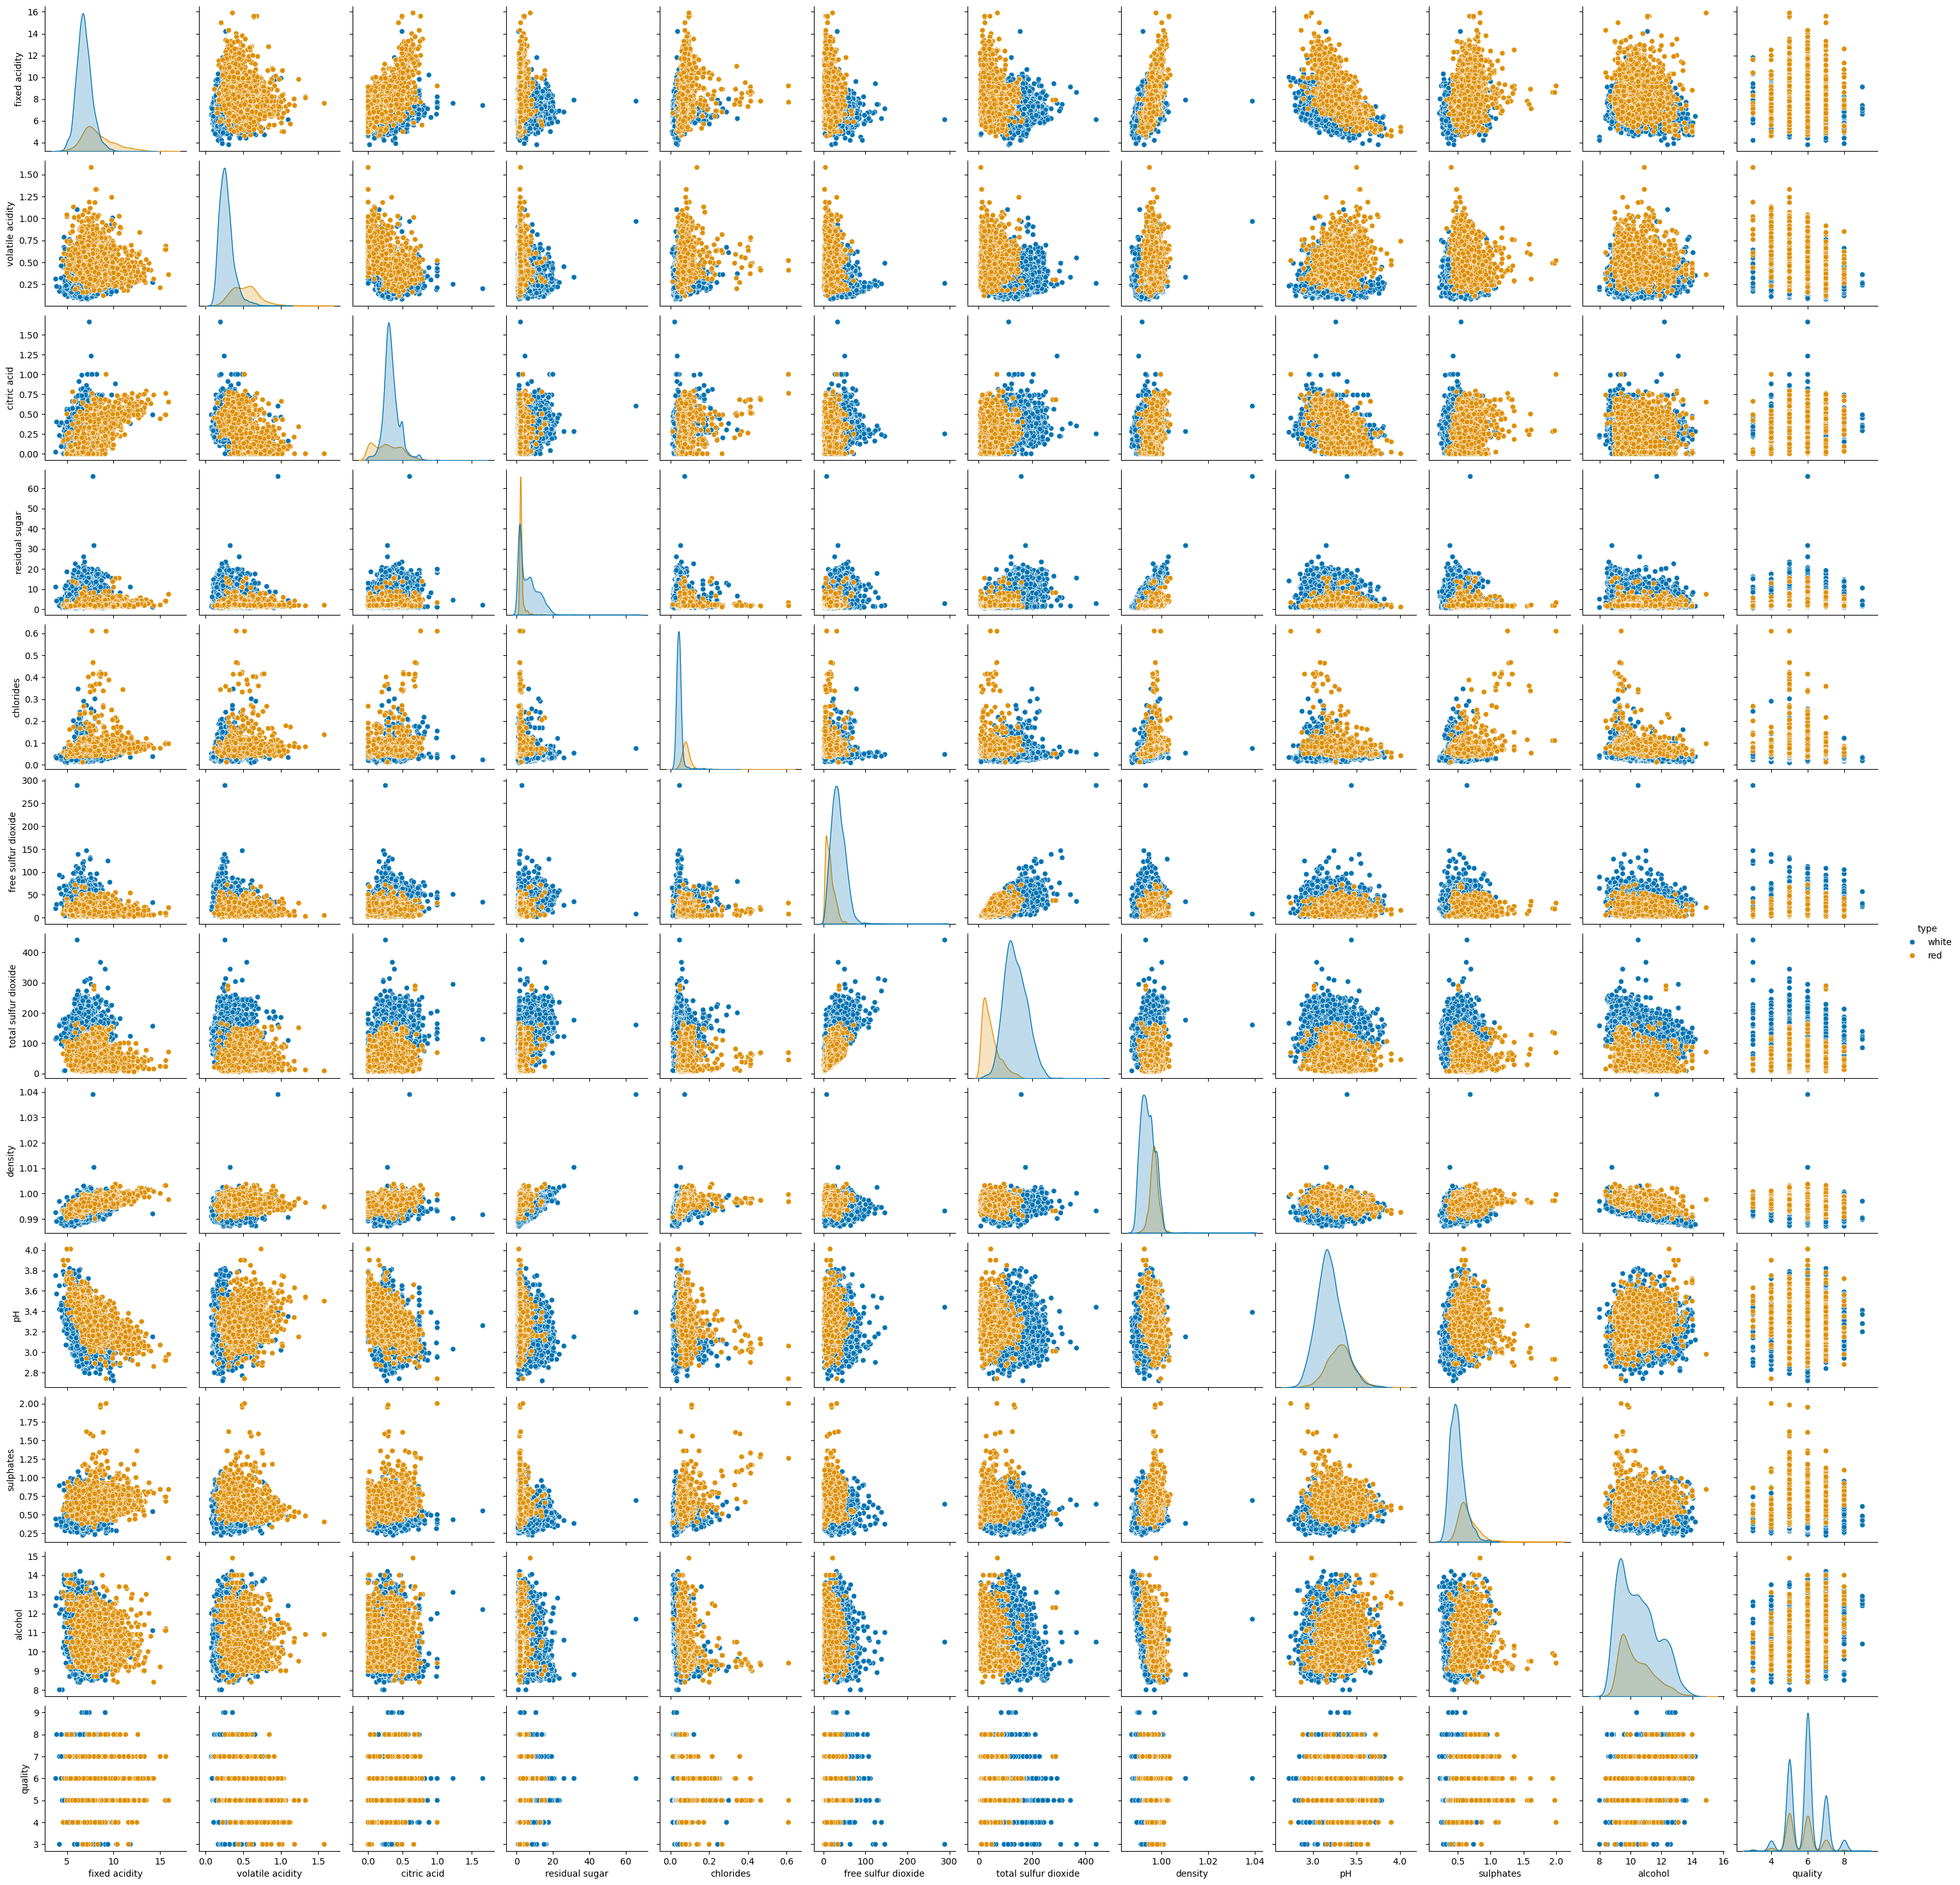

In [12]:
sns.pairplot(wine_data, hue="type", palette = 'colorblind')

# Model creation 1

Now that we have a good understanding of our data, it is time to build the model to predict wine type. The first thing that you need to do is split your model into a training and a testing set. When splitting the data create a 80-20 train-test split. Do not forget to make sure your prediction class ("type") is balanced between the training and testing sets. 

In [14]:
#divide into training and testing
train, test = train_test_split(wine_data, test_size = .2, stratify = wine_data['type'], random_state = 0)

#divide into x and y
x_train = train[["chlorides", "volatile acidity", "total sulfur dioxide"]]#fill in with the columns you want to predict
y_train = train["type"]

x_test = test[["chlorides", "volatile acidity", "total sulfur dioxide"]]# fill in with the same columns as x_train
y_test = test["type"]

In the cell below, use a Decision Tree classifier and your above split into training and testing data to create a model to predict wine type. **Do not** limit the depth of the tree, and print out the *accuracy* of the model you created. 

In [16]:
#build your model
mod_wine_data_1 = DecisionTreeClassifier(random_state = 1) #declare model "estimator"
mod_wine_data_1.fit(x_train, y_train)
wine_data_pred_1 = mod_wine_data_1.predict(x_test)
print("accuracy: ", metrics.accuracy_score(wine_data_pred_1,y_test))

accuracy:  0.9775715390564579


In the cell below, display the features used in the model and also how important each feature was in the decision tree you created. Do the feature importances align with how predictive you thought each feature would be based on the pairplots above?

**Answer here:** Yes, it did. I initially predicted total sulfur dioxide as the most important factor for prediction, and it turned out to be so at 0.69917491. I assumed chlorides would be important too, and they were at 0.23355555. I thought volatile acidity would be somewhat helpful while not being the most important and it was at 0.06726954. All of them contributed to determining the accuracy.

In [18]:
#ordered as follows: ["chlorides", "volatile acidity", "total sulfur dioxide"]
mod_wine_data_1.feature_importances_

array([0.23355555, 0.06726954, 0.69917491])

Visualize the tree in the next cell.

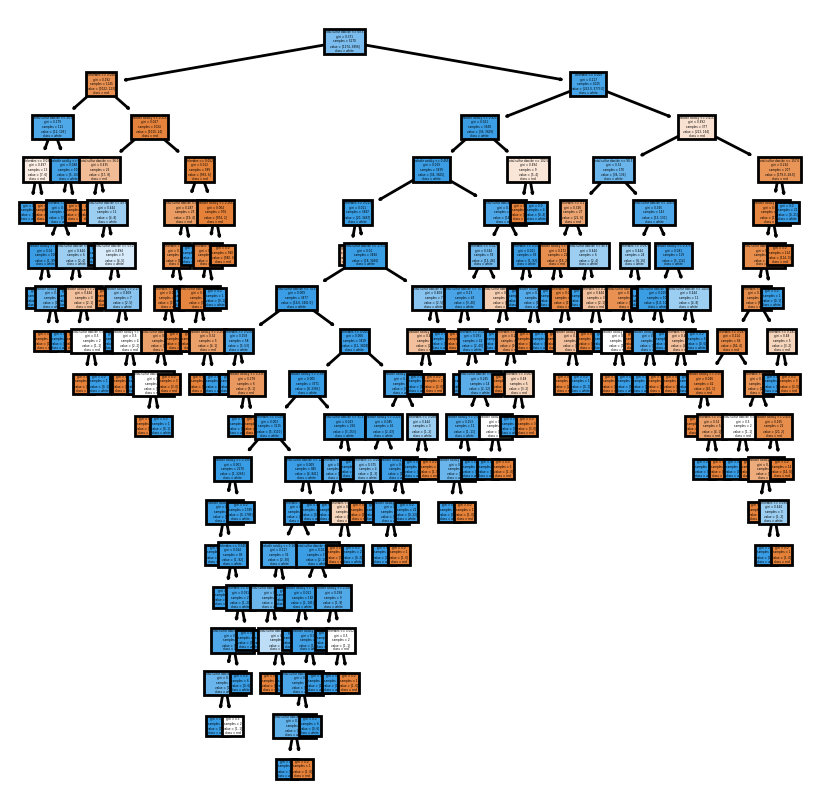

In [20]:
plt.figure(figsize = (5,5), dpi = 200)
plot_tree(mod_wine_data_1,feature_names=x_train.columns,class_names=mod_wine_data_1.classes_, filled = True)
plt.show()

Notably, this tree is much larger than the tree we created in assignment 6. Are there any concerns about making a tree this large/complex (think - what happens if the model's decision boundaries get too complex?)?

**Answer here:** Yes, I'm a little worried because this data is somewhat overfit. It has almost too much depth, and people who are not technical may not be able to understand it. A lot of the separations made to create this tree are probably somewhat unrealistic.

Would the model lose any accuracy if we forced it to be simpler? In the following cell, recreate your decision tree model but limit the depth of the tree to 5. Print the accuracy and visualize the tree.

**Answer here:** It did not lose any accuracy when I simplified it; in fact, it actually improved to a little over 0.98.

In [22]:
#build your model
mod_wine_data_2 = DecisionTreeClassifier(max_depth=5, random_state = 1) #declare model "estimator"
mod_wine_data_2.fit(x_train, y_train)
wine_data_pred_2 = mod_wine_data_2.predict(x_test)
print("accuracy: ", metrics.accuracy_score(wine_data_pred_1,y_test))

accuracy:  0.9775715390564579


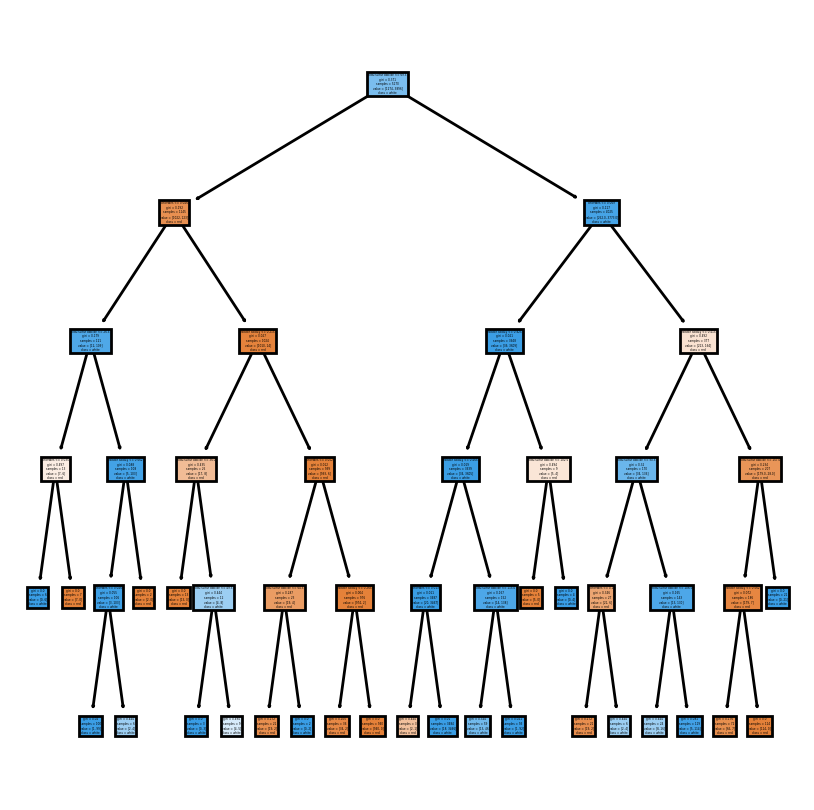

In [23]:
plt.figure(figsize = (5,5), dpi = 200)
plot_tree(mod_wine_data_2,feature_names=x_train.columns,class_names=mod_wine_data_2.classes_, filled = True)
plt.show()

How does this model compare to the model with unlimited depth? Is there an advantage to using the simpler model?

**Answer here:** This model compares very favorably to the original. It’s much easier to read, even for a non-technical user, and the accuracy improved with the limit. With the limit on the data, people can more easily predict the type of wine they're drinking and understand it better. Additionally, it helps prevent overfitting with the given data.

In the following cells, try building a model without stratifying the training and testing set. Specifically, recreate your training set to be the first 4500 rows from the data and the testing set being the remaining rows. Then use these sets to rebuild your decision tree model. Print out the accuracy, precision, and recall from your model.

In [25]:
#created x and y to separate data by columns
x = wine_data.drop('type', axis=1)  #all features except for the 'type' column
y = wine_data['type']  #only the 'type column

#split the data
#first 4500 rows for training, remaining rows for testing
x_train = x.iloc[:4500]
y_train = y.iloc[:4500]

x_test = x.iloc[4500:]
y_test = y.iloc[4500:]

#create and train the decision tree classifier model
model = DecisionTreeClassifier(random_state=1)
model.fit(x_train, y_train)

#make predictions on the test set
y_pred = model.predict(x_test)

#calculate the accuracy, precision, and recall values
accuracy = metrics.accuracy_score(y_test, y_pred)
precision_white = metrics.precision_score(y_test, y_pred, pos_label='white')  #pos_label for type of wine
precision_red = metrics.precision_score(y_test, y_pred, pos_label='red')
recall_white = metrics.recall_score(y_test, y_pred, pos_label='white')  #pos_label for type of wine
recall_red = metrics.recall_score(y_test, y_pred, pos_label='red')

# Print the metrics
print(accuracy)
print(precision_white)
print(precision_red)
print(recall_white)
print(recall_red)

0.18848700967906265
0.18848700967906265
0.0
1.0
0.0


C:\Users\marchelloa\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


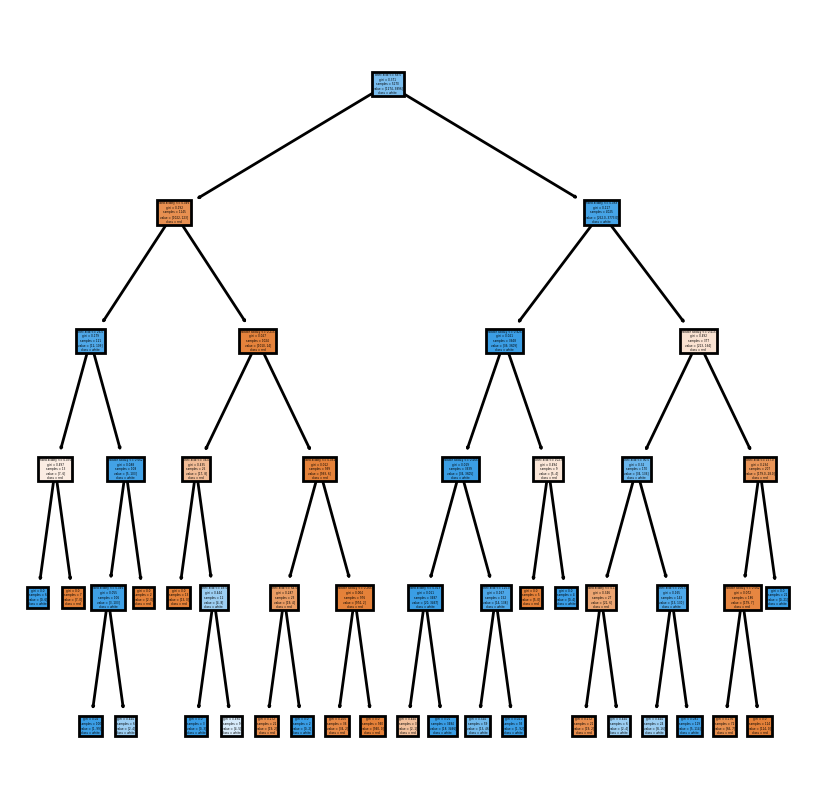

In [26]:
plt.figure(figsize = (5,5), dpi = 200)
plot_tree(mod_wine_data_2,feature_names=x_train.columns,class_names=mod_wine_data_2.classes_, filled = True)
plt.show()

What is going on here? Why does this model perform so terribly? (For reference, your accuracy should be just under 20%).

**Answer here:** This model is performing terribly because it was only trained on white wine, but it's being tested on a mix of white and red wine, mostly red. Since the model was never trained to identify red wine, it can easily identify white wine but not red, as it doesn't know the traits of red wine. Additionally, if I set the precision and recall values to target white wine, the precision would match the accuracy because that reflects the percentage of white wine in the test data, and the recall value would be 1, as that’s what it was trained for. However, if I set the precision and recall values to target red wine, both values would be 0, leading to an error because the model wasn’t trained to identify red wine, which is why both values are 0.

# Model 2: Predicting wine quality

Finally, build a new model model on your own predicting the "quality" column of the data set. Use a model other than a decision tree (refer to assignment 6 or do your own research for a different classification algorithm). You will likely want to remove the non-numeric "type" column from your predictions (or, if you would rather, recode this column to be numeric). Print out the accuracy of your new model.

Your should achieve an accuracy of at least 46%.

In [29]:
#divide into training and testing
train, test = train_test_split(wine_data, test_size = .2, stratify = wine_data['type'], random_state = 0)

#divide into x and y
x_train = train[["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide",
                 "total sulfur dioxide","density","pH","sulphates","alcohol"]]#fill in with the columns you want to predict
y_train = train["quality"]

x_test = test[["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide",
               "total sulfur dioxide","density","pH","sulphates","alcohol"]]# fill in with the same columns as x_train
y_test = test["quality"]

#build your model
mod_wine_data_3 = LogisticRegression(solver='liblinear', multi_class='ovr') #declare model "estimator"
mod_wine_data_3.fit(x_train, y_train)
wine_data_pred_3 = mod_wine_data_3.predict(x_test)
print("accuracy: ", metrics.accuracy_score(wine_data_pred_3,y_test))

accuracy:  0.5367362722351121


When predicting "quality" you likely did not achieve an accuracy anywhere near 98% like you did for predicting "type". What makes "quantity" an inherently more difficult thing to predict than "type"?

**Answer here:** My "quality" prediction accuracy was only about 0.5367 because there isn't a defining column that directly correlates with a specific trait for "quality". I used all the available data, except for "type", to see if I could establish a connection. Since "quality" is subjective, and the score given is a "quantity" not based on clear values, it’s very hard to predict. At least for "type", even if you can’t provide the color, there are distinct traits between red and white wines. However, "quality" is a subjective score based on how the wine was made, not on the data in the table. This makes it difficult to identify a measurable "quantity".

This was likely (for most students) your first chance at building a machine learning model on your own. Please provide a brief reflection on the activity, including any concepts that were discussed here or in a previous lecture that you have questions about, or topics that you would like to learn more about. 

**Answer here:** I learned that not every trait in a data table can be easily predicted, as not all of them are linked, much like "quality" in this lab. I was able to build models with the help of some example code from Assignment 6 and online resources. I also learned that setting model depths can sometimes improve accuracy. If you don't set depths, your model is likely to overfit the current data and may not generalize well to other datasets. I'm very excited for future labs on this topic and hope to improve my ability to identify relationships in data, as well as be mindful of data splits. I don’t have any questions for now.

This lab was created by Dr. Gabe Wright